# pbc bands and obc eigenvalues

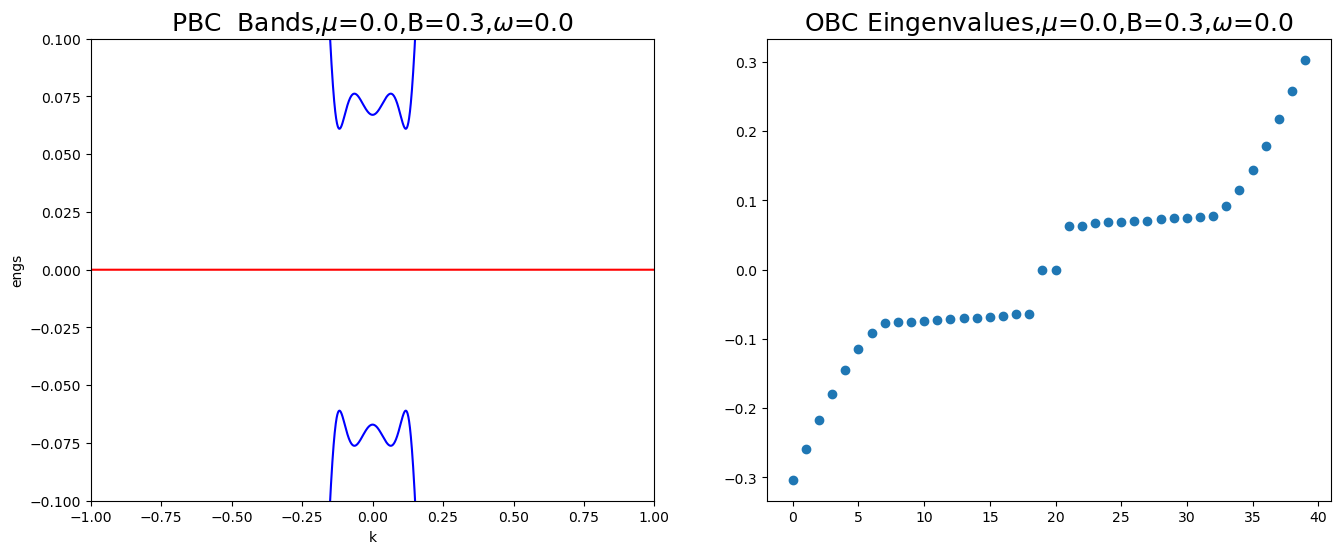

Energy Gap: 0.06101790763478239


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import kwant
import time
from numpy import sqrt,pi,cos,sin,kron
from scipy.sparse.linalg import eigsh

#pauli matrix
sigma_0 = np.array([[1, 0],[0, 1]])
sigma_x = np.array([[0, 1],[1, 0]])
sigma_y = np.array([[0, -1j],[1j, 0]])
sigma_z = np.array([[1, 0],[0, -1]])

tau_0 = sigma_0
tau_x = sigma_x
tau_y = sigma_y
tau_z = sigma_z


'''固定参数'''
hbar = 1.055e-34    #J.S  
me = 9.109e-31    #kg
meff = 0.03*me
delta0 = 0.12   #meV


a = 1e-8 #m
L = 300

#g·mu_B的值
gmu = 1.447  #meV/T
meV = 1.60217e-22
t = hbar**2/(2*meff*a**2)/meV   #量纲为meV
gamma = 0.15 #meV
alpha = 0.8  #约化Rashba，等于alpha/a,单位为meV


'''变化参数'''
B = 0.3
mu = 0.0
omega = 0.0
#self energy
def self_eng(omega):
    return -gamma * (omega*kron(tau_0,sigma_0) + delta0 * kron(tau_x,sigma_0)) / sqrt(delta0**2 - omega**2)

def make_sys(B,mu,omega=0,PBC=True):
    if PBC:
        sys = kwant.Builder(kwant.TranslationalSymmetry((1,0)))
    else:
        sys = kwant.Builder()

    lat = kwant.lattice.square(a=1,norbs=4)

    es = 1e-3
    def system_shape(pos):
        return -L//2 - es < pos[0] < L//2 + es and 0 - es < pos[1] < 1
    
    def lead_left(pos):
        return 0-es < pos[1] < 1 
    def lead_right(pos):
        return 0-es < pos[1] < 1 
    
    def onsite_SC(site):
        return (2 * t - mu) * kron(tau_z,sigma_0) + self_eng(omega) + 1/2 * gmu * B * kron(tau_0,sigma_x) 
    
    def hoppingx(site1,site2):
        x,y = site1.pos
        return  -t*kron(tau_z,sigma_0) + 1j*alpha/2*kron(tau_z,sigma_y) 

    sys[lat.shape(system_shape, (0, 0))] = onsite_SC
    sys[kwant.builder.HoppingKind((1, 0), lat, lat)] = hoppingx
    return sys

def main():
    '''sys_bands,omega=0'''
    sys = make_sys(B,mu,omega=omega,PBC=True).finalized()

    band_sys = kwant.physics.Bands(sys)
    momenta = np.linspace(-pi, pi, 10001)
    eng_sys = np.array([band_sys(k) for k in momenta])

    zero = np.zeros(len(momenta))


    title_dict = {'fontsize': 18}
    plt.figure(figsize=(16,6))

    plt.subplot(1,2,1)
    plt.plot(momenta, eng_sys,'b')
    plt.plot(momenta, zero,'r')
    plt.xlabel('k')
    plt.ylabel('engs')   
    plt.ylim(-0.1,0.1)
    plt.xlim(-1,1)
    plt.title(f'PBC  Bands,$\\mu$={mu},B={B},$\\omega$={omega}', **title_dict)


    '''eigenvalues'''
    system = make_sys(B,mu,omega=omega,PBC=False).finalized()
    hamiltonian = system.hamiltonian_submatrix(sparse=True)
    energies = eigsh(hamiltonian, k=40, sigma=1e-10, return_eigenvectors=False)
    eng = np.sort(energies)


    plt.subplot(1,2,2)
    plt.plot(eng,'o')
    plt.title(f'OBC Eingenvalues,$\\mu$={mu},B={B},$\\omega$={omega}', **title_dict)
    plt.savefig('Bands.eps', format='pdf', dpi=300, bbox_inches='tight')
    plt.show()


    # 计算pbc的gap（BdG 对称）
    min_positive_energy = np.min(eng_sys[eng_sys > 0])
    max_negative_energy = np.max(eng_sys[eng_sys < 0])
    gap = (min_positive_energy - max_negative_energy)/2
    print("Energy Gap:", gap)
    
if __name__ == '__main__':
    main()


# LDos 

[ 2.46441615e-06 -2.46441614e-06 -6.35999789e-02 -6.37983850e-02
  6.35999789e-02  6.37983850e-02  6.75487430e-02 -6.75487430e-02
  6.88077926e-02 -6.88077926e-02]


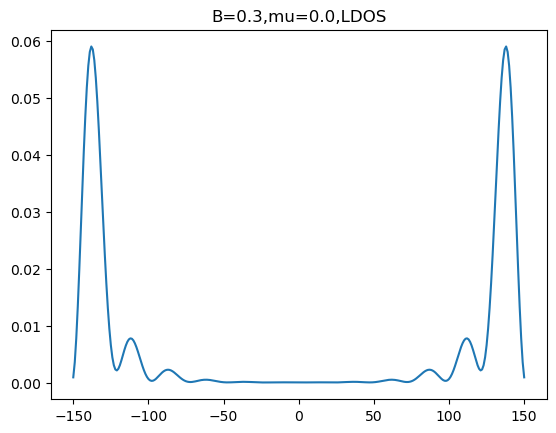

In [14]:
'''LDos'''
def make_sys(B,omega,mu):
    lat = kwant.lattice.square(a=1,norbs=4)
    sys = kwant.Builder()
    es = 1e-3
    def system_shape(pos):
        return -L//2 - es < pos[0] < L//2 + es and 0-es < pos[1]<1
    
    def lead_left(pos):
        return 0-es < pos[1] < 1 
    def lead_right(pos):
        return 0-es < pos[1] < 1 
    
    def onsite_SC(site):
        return (2*t-mu)*kron(tau_z,sigma_0) + self_eng(omega) + 1/2*gmu*B*kron(tau_0,sigma_x) 
    
    def hoppingx(site1,site2):
        x,y = site1.pos
        return  -t*kron(tau_z,sigma_0) + 1j* alpha/2 * kron(tau_z,sigma_y) 

    sys[lat.shape(system_shape, (0, 0))] = onsite_SC
    sys[kwant.builder.HoppingKind((1, 0), lat, lat)] = hoppingx
    return sys

system = make_sys(B,0,mu)
# kwant.plot(system)
system = system.finalized()
hamiltonian = system.hamiltonian_submatrix(sparse=True)
energies,states = eigsh(hamiltonian, k=10, sigma=1e-10, return_eigenvectors=True)
print(energies)
rho = kwant.operator.Density(system)
density = rho(states[:,0]) + rho(states[:,1])  #两个低能态


Xs = np.arange(-L//2, L//2 + 1)
plt.figure()
plt.plot(Xs,density)
plt.title(f'B={B},mu={mu},LDOS')
plt.show()
